# Training Neural Networking on MNST numbers

## Setup:

In [90]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Load and Visualization

In [2]:
# Load MNIST data directly from TensorFlow
mnist = tf.keras.datasets.mnist
# Split the dataset into training and testing data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Print out the dimensions
print("Dimension of Training Images: ", train_images.shape)
print("Dimension of Training Labels: ", train_labels.shape)
print("Dimension of Test Images: ", test_images.shape)
print("Dimension of Test Labels: ", test_labels.shape)

Dimension of Training Images:  (60000, 28, 28)
Dimension of Training Labels:  (60000,)
Dimension of Test Images:  (10000, 28, 28)
Dimension of Test Labels:  (10000,)


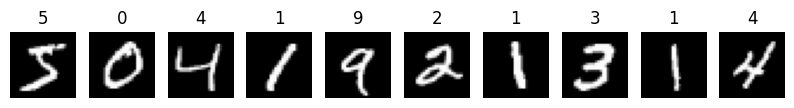

In [99]:
# Visualize the first 10 images from the training set
def plot_images(images, labels, num=10, num_per_row = 10):
    num_rows = (num) // num_per_row
    plt.figure(figsize=(num_per_row, num_rows * 2))
    for i in range(num):
        plt.subplot(num_rows, num_per_row, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
        plt.title(labels[i])
    plt.show()

# Plot the first 10 images from the training set
plot_images(train_images, train_labels, 10)

## Preprocessing

In [5]:
# Flatten the images for both train and test sets
train_images_flattened = train_images.reshape(-1, 28 * 28)
test_images_flattened = test_images.reshape(-1, 28 * 28)

# Normalize pixel values to be between 0 and 1
train_images_flattened = train_images_flattened / 255.0
test_images_flattened = test_images_flattened / 255.0

# One-hot encode the labels
train_labels_one_hot = np.eye(10)[train_labels]
test_labels_one_hot = np.eye(10)[test_labels]

In [9]:
# Print out the dimensions
print("Dimension of Training Images: ", train_images_flattened.shape)
print("Dimension of Training Labels: ", train_labels_one_hot.shape)
print("Dimension of Test Images: ", test_images_flattened.shape)
print("Dimension of Test Labels: ", test_labels_one_hot.shape)

Dimension of Training Images:  (60000, 784)
Dimension of Training Labels:  (60000, 10)
Dimension of Test Images:  (10000, 784)
Dimension of Test Labels:  (10000, 10)


## Designing The Model

In [91]:
class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layers, output_size, activation="relu", reg_type=None, reg_lambda=0.0, leaky_slope=0.01):
        """
        Initialize the MLP with given parameters.
        input_size: Number of input features.
        hidden_layers: List with the number of units in each hidden layer.
        output_size: Number of output units.
        activation: Activation function ("relu", "tanh" or "leaky_relu").
        reg_type: Regularization type ("l1", "l2", or None).
        reg_lambda: Regularization strength.
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i + 1]) * 0.1 for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i + 1])) for i in range(len(self.layers) - 1)]
        self.activation = activation.lower()
        self.reg_type = reg_type.lower() if reg_type else None
        self.reg_lambda = reg_lambda
        self.leaky_slope = leaky_slope
        # save the weights that works the best on val during training
        self.best_weights = deepcopy(self.weights)
        self.best_biases = deepcopy(self.biases)
        self.best_val_acc = 0
    def _activation(self, z):
        """
        Apply the chosen activation function.
        Pre-activation values.
        Activation values.
        """
        if self.activation == "relu":
            return np.maximum(0, z)                           # ReLU
        elif self.activation == "tanh":
            return np.tanh(z)                                 # Tanh
        elif self.activation == "leaky_relu":
            return np.where(z > 0, z, self.leaky_slope * z)   # Leaky ReLU
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")

    def _activation_derivative(self, z):
        """
        Compute the derivative of the chosen activation function.
        z: Pre-activation values.
        return: Derivative of activation values.
        """
        if self.activation == "relu":
            return (z > 0).astype(float)                      # ReLU derivative
        elif self.activation == "tanh":
            return 1 - np.tanh(z) ** 2                        # Tanh derivative
        elif self.activation == "leaky_relu":
            return np.where(z > 0, 1, self.leaky_slope)       # Leaky ReLU derivative
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")

    def _softmax(self, z):
        """
        Apply softmax to compute output probabilities.
        z: Pre-activation values of the output layer.
        return: Softmax probabilities.
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Perform forward propagation.
        X: Input data.
        return: Activations and pre-activations for each layer.
        """
        activations = [X]
        pre_activations = []

        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            pre_activations.append(z)
            if i == len(self.weights) - 1:                    # Output layer
                a = self._softmax(z)
            else:                                             # Hidden layers
                a = self._activation(z)
            activations.append(a)

        return activations, pre_activations


    def forward_best(self, X):
        """
        Perform forward propagation.
        X: Input data.
        return: Activations and pre-activations for each layer.
        Use the best weights and biases
        """
        activations = [X]
        pre_activations = []

        for i in range(len(self.best_weights)):
            z = np.dot(activations[-1], self.best_weights[i]) + self.best_biases[i]
            pre_activations.append(z)
            if i == len(self.best_weights) - 1:             # Output layer
                a = self._softmax(z)
            else:                                           # Hidden layers
                a = self._activation(z)
            activations.append(a)

        return activations, pre_activations

    def backward(self, X, y, activations, pre_activations):
        """
        Perform backward propagation to compute gradients for weights and biases.
        X: Input minibatch data.
        y: Ground truth labels (one-hot encoded).
        activations: List of activations from forward pass.
        re_activations: List of pre-activations (z values) from forward pass.
        return: Gradients for weights and biases.
        """
        m = X.shape[0]                                      # Minibatch size
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        # Output layer delta
        delta = activations[-1] - y
        grads_w[-1] = np.dot(activations[-2].T, delta) / m
        # print(delta.shape)
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m

        # Backpropagation for hidden layers
        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[l + 1].T) * self._activation_derivative(pre_activations[l])
            grads_w[l] = np.dot(activations[l].T, delta) / m
            grads_b[l] = np.sum(delta, axis=0, keepdims=True) / m
            if self.reg_type == "l2":
                grads_w[l] += self.reg_lambda * self.weights[l]
            elif self.reg_type == "l1":
                grads_w[l] += self.reg_lambda * np.sign(self.weights[l])

        return grads_w, grads_b

    def update_params(self, grads_w, grads_b, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i] -= learning_rate * grads_b[i]

    def fit(self, X, y, X_val, y_val, epochs, learning_rate, batch_size, regularization=None):

        for epoch in tqdm(range(epochs)):
            # Shuffle the data
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Minibatch training
            for start in range(0, X.shape[0], batch_size):
                end = min(start + batch_size, X.shape[0])
                X_batch = X[start:end]
                y_batch = y[start:end]

                # Forward pass
                activations, pre_activations = self.forward(X_batch)

                # Backward pass
                grads_w, grads_b = self.backward(X_batch, y_batch, activations, pre_activations)

                # Update weights and biases
                self.update_params(grads_w, grads_b, learning_rate)

            # Evaluate accuracy after each epoch
            train_acc = self.evaluate_acc(X, y)
            val_acc = self.evaluate_acc(X_val, y_val)

            if val_acc > self.best_val_acc:
                self.best_weights = deepcopy(self.weights)
                self.best_biases = deepcopy(self.biases)
                self.best_val_acc = val_acc
            print(f"Epoch {epoch}: Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

    def predict_best(self, X):
        activations, _ = self.forward_best(X)
        return np.argmax(activations[-1], axis=1)

    def evaluate_acc(self, X, y):
        predictions = self.predict(X)
        y_true = np.argmax(y, axis=1)
        return accuracy_score(y_true, predictions)

    def evaluate_acc_best(self, X, y):
        predictions = self.predict_best(X)
        y_true = np.argmax(y, axis=1)
        return accuracy_score(y_true, predictions)

In [97]:
input = 784
hidden = [10]
output = 10

model = MultilayerPerceptron(input, hidden, output, "ReLu")
model.fit(train_images_flattened, train_labels_one_hot, test_images_flattened, test_labels_one_hot, 10, 0.05, 50)

 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

Epoch 0: Train Accuracy: 0.8907, Val Accuracy: 0.8960


 20%|██        | 2/10 [00:01<00:07,  1.08it/s]

Epoch 1: Train Accuracy: 0.9119, Val Accuracy: 0.9148


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

Epoch 2: Train Accuracy: 0.9186, Val Accuracy: 0.9228


 40%|████      | 4/10 [00:03<00:05,  1.19it/s]

Epoch 3: Train Accuracy: 0.9238, Val Accuracy: 0.9252


 50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

Epoch 4: Train Accuracy: 0.9258, Val Accuracy: 0.9253


 60%|██████    | 6/10 [00:05<00:03,  1.24it/s]

Epoch 5: Train Accuracy: 0.9301, Val Accuracy: 0.9295


 70%|███████   | 7/10 [00:05<00:02,  1.24it/s]

Epoch 6: Train Accuracy: 0.9319, Val Accuracy: 0.9296


 80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

Epoch 7: Train Accuracy: 0.9354, Val Accuracy: 0.9338


 90%|█████████ | 9/10 [00:07<00:00,  1.26it/s]

Epoch 8: Train Accuracy: 0.9379, Val Accuracy: 0.9353


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

Epoch 9: Train Accuracy: 0.9378, Val Accuracy: 0.9352


[5 0 4 1 9 2 1 3 1 4]


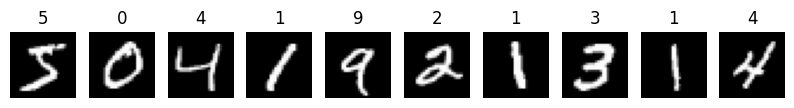

In [104]:
inference = model.predict(train_images_flattened[0:10])
print(inference)

# Plot the first 10 images from the training set and add the inference label instead
plot_images(train_images, inference, 10)